In [1]:
import pandas as pd
import numpy as np

import rasterio as rio
import geopandas as gpd
from src import patch_samples,_stretch_im

from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns

import os,sys

# Normlize Rasters

In [2]:
!ls ../data/s2_data/

B02.tif  B03.tif  B04.tif  B08.tif


In [3]:
list_image_4328 = [rio.open(f'../data/s2_data/{img}').read() for img in ['B04.tif', 'B03.tif', 'B02.tif', 'B08.tif']]
list_image_4328[0].shape

(1, 10980, 10980)

In [5]:
list_image_4328_norm = [img/img.max() for img in list_image_4328]
list_image_4328_norm[0].shape

(1, 10980, 10980)

In [6]:
S2_B4328_10m = np.concatenate(list_image_4328_norm)
S2_B4328_10m.shape, S2_B4328_10m.dtype

((4, 10980, 10980), dtype('float64'))

In [7]:
profile = rio.open(f'../data/s2_data/B02.tif').profile
profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32654), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4000020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [8]:
profile['count'] = 4
profile['dtype'] = 'float32'

In [9]:
with rio.open('../data/Sentinel-2_B4328_10m.tif', 'w', **profile) as dst_dataset:
    dst_dataset.write(S2_B4328_10m.astype('float32'))
    

# Prepare Patches

In [10]:
train_data = patch_samples('../data/ground_truth/terrain_truth_epsg32654_A.tif', 16, 500, strata=True)
test_valid_data = patch_samples('../data/ground_truth/terrain_truth_epsg32654_B.tif', 16, 500, strata=True)

In [11]:
train_data.head()

,value,geometry
0,0,"POLYGON ((391885.000 3948565.000, 391885.000 3..."
1,0,"POLYGON ((383965.000 3961505.000, 383965.000 3..."
2,0,"POLYGON ((351995.000 3913955.000, 351995.000 3..."
3,0,"POLYGON ((311115.000 3979025.000, 311115.000 3..."
4,0,"POLYGON ((317875.000 3897785.000, 317875.000 3..."


In [12]:
test_valid_data.tail()

,value,geometry
2995,5,"POLYGON ((358505.000 3984095.000, 358505.000 3..."
2996,5,"POLYGON ((366385.000 3974855.000, 366385.000 3..."
2997,5,"POLYGON ((372515.000 3987335.000, 372515.000 3..."
2998,5,"POLYGON ((379345.000 3973145.000, 379345.000 3..."
2999,5,"POLYGON ((359115.000 3987765.000, 359115.000 3..."


In [13]:
train_data.to_file('../data/train_data.geojson', driver='GeoJSON')  

In [14]:
# Get the split indexes
strat_shuf_split = ShuffleSplit(n_splits=1, 
                                test_size=0.1, 
                                random_state=125)

valid_idx, test_idx = next(strat_shuf_split.split(test_valid_data.geometry, test_valid_data.value))

In [15]:
valid_idx.shape, test_idx.shape

((2700,), (300,))

In [16]:
valid_data = test_valid_data.iloc[valid_idx, :]
test_data = test_valid_data.iloc[test_idx, :]

In [17]:
valid_data.to_file('../data/valid_data.geojson', driver='GeoJSON')  
test_data.to_file('../data/test_data.geojson', driver='GeoJSON')  

# Visualization

In [18]:
src = rio.open(f'../data/Sentinel-2_B4328_10m.tif')

In [19]:
minx, miny, maxx, maxy = src.bounds

In [20]:
image = _stretch_im(src.read([1,2,3]),1)

In [21]:
LULC_ENC = {0: "Water", 1: "Golf course", 2: "Park and grassland", 3: "Buildings", 4: "Forest", 5:"Farm"}

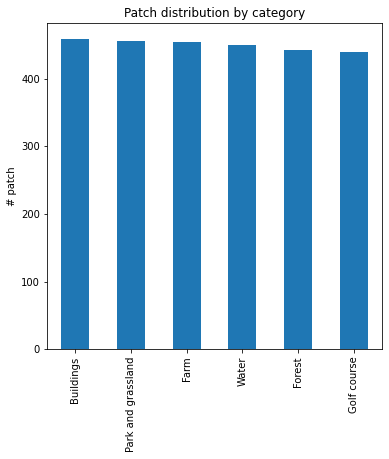

In [22]:
plt.figure(figsize=(6,6))
valid_data.value.value_counts().rename(LULC_ENC).plot(kind="bar")
plt.ylabel("# patch")
plt.title("Patch distribution by category", fontsize=12);

In [23]:
train_data.value = train_data.value.map(LULC_ENC)

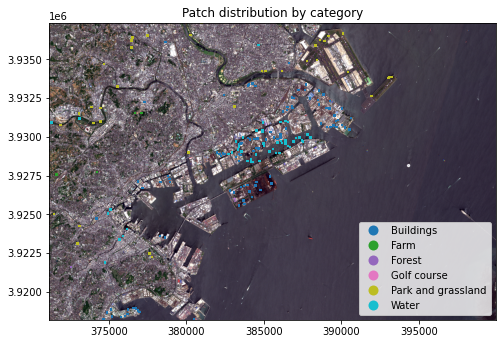

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(np.moveaxis(np.clip(image,0,1),0,-1),extent=(minx, maxx, miny, maxy))
train_data.plot(ax=plt.gca(), alpha=1,column="value", categorical=True,legend=True,legend_kwds={'loc':'lower right'})

plt.gca().set_xlim(371152.830,399937.861)
plt.gca().set_ylim(3918197.883,3937348.944)

plt.title("Patch distribution by category", fontsize=12);
plt.show()